# 16 shots linear probing CLIP on EuroSAT

In [11]:
import os
import numpy as np
import torch
import clip
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random

np.random.seed(2024)
torch.manual_seed(2024)

# Define a simple dataset class
class EuroSATDataset(Dataset):
    def __init__(self, file_paths, labels, preprocess):
        self.file_paths = file_paths
        self.labels = labels
        self.preprocess = preprocess

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(file_path).convert("RGB")
        if self.preprocess:
            image = self.preprocess(image)
        return image, label

# Define a simple classifier
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        # Simple linear layer as classifier
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# Load the CLIP model and preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define EuroSAT class names
eu_sat_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
                  'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
class_to_index = {cls: index for index, cls in enumerate(eu_sat_classes)}

# Load and split the EuroSAT dataset
eu_sat_dir = './data'
train_files = []
val_files = []
test_files = []
train_labels = []
val_labels = []
test_labels = []

for cls in eu_sat_classes:
    cls_dir = os.path.join(eu_sat_dir, cls.replace(' ', '_'))
    filenames = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(filenames)  # Shuffle the filenames
    train_files.extend(filenames[:16])  # First 16 for training
    train_labels.extend([class_to_index[cls]] * 16)
    val_files.extend(filenames[16:32])  # Next 16 for validation
    val_labels.extend([class_to_index[cls]] * 16)
    test_files.extend(filenames[:])  # Whole dataset for testing
    test_labels.extend([class_to_index[cls]] * len(filenames[:]))

# Create dataset objects for each split
train_dataset = EuroSATDataset(train_files, train_labels, preprocess)
val_dataset = EuroSATDataset(val_files, val_labels, preprocess)
test_dataset = EuroSATDataset(test_files, test_labels, preprocess)

# Create data loaders for each split
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the classifier, optimizer, and loss function
input_dim = model.visual.output_dim  # Assuming using CLIP's image feature dimension
num_classes = len(eu_sat_classes)

classifier = SimpleClassifier(input_dim, num_classes).to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [18]:
num_epochs = 200
validation_interval = 30  # Validate after every 30 epochs
save_interval = 50  # Save after every 50 epochs
early_stopping_patience = 30  # Number of epochs to wait for loss improvement
best_val_accuracy = 0  # Track best validation accuracy
no_improvement_epochs = 0  # Track epochs without improvement for early stopping
model_save_path = './models/best_model.pth'  # Path to save the best model

for epoch in range(num_epochs):
    classifier.train()  # Ensure the classifier is in training mode
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            image_features = model.encode_image(images).float()
            image_features /= image_features.norm(dim=-1, keepdim=True)
        outputs = classifier(image_features)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

    if (epoch + 1) % validation_interval == 0:
        classifier.eval()  # Set the classifier to evaluation mode
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Validation at Epoch {epoch+1}"):
                images, labels = images.to(device), labels.to(device)
                image_features = model.encode_image(images).float()
                image_features /= image_features.norm(dim=-1, keepdim=True)
                outputs = classifier(image_features)
                predicted = outputs.argmax(dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Accuracy at Epoch {epoch+1}: {val_accuracy:.2f}%")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(classifier.state_dict(), model_save_path)
            print(f"Best model saved at Epoch {epoch+1}")
            no_improvement_epochs = 0  # Reset counter
        else:
            no_improvement_epochs += validation_interval
            if no_improvement_epochs >= early_stopping_patience:
                print(f"No improvement in validation accuracy for {early_stopping_patience} epochs, stopping training.")
                break  # Early stopping

        classifier.train()  # Set the classifier back to training mode

    # Save the model periodically
    if (epoch + 1) % save_interval == 0:
        periodic_save_path = f'./models/model_epoch_{epoch+1}.pth'
        torch.save(classifier.state_dict(), periodic_save_path)
        print(f"Model saved at Epoch {epoch+1} to {periodic_save_path}")

Training Epoch 1/200: 100%|██████████| 10/10 [00:00<00:00, 38.28it/s]


Epoch 1, Loss: 1.8561373829841614


Training Epoch 2/200: 100%|██████████| 10/10 [00:00<00:00, 41.38it/s]


Epoch 2, Loss: 1.8378044605255126


Training Epoch 3/200: 100%|██████████| 10/10 [00:00<00:00, 39.93it/s]


Epoch 3, Loss: 1.8201332807540893


Training Epoch 4/200: 100%|██████████| 10/10 [00:00<00:00, 40.54it/s]


Epoch 4, Loss: 1.8023634195327758


Training Epoch 5/200: 100%|██████████| 10/10 [00:00<00:00, 40.88it/s]


Epoch 5, Loss: 1.783688199520111


Training Epoch 6/200: 100%|██████████| 10/10 [00:00<00:00, 40.83it/s]


Epoch 6, Loss: 1.7662944674491883


Training Epoch 7/200: 100%|██████████| 10/10 [00:00<00:00, 40.52it/s]


Epoch 7, Loss: 1.7487669944763184


Training Epoch 8/200: 100%|██████████| 10/10 [00:00<00:00, 40.00it/s]


Epoch 8, Loss: 1.7318480372428895


Training Epoch 9/200: 100%|██████████| 10/10 [00:00<00:00, 38.17it/s]


Epoch 9, Loss: 1.7152376294136047


Training Epoch 10/200: 100%|██████████| 10/10 [00:00<00:00, 40.16it/s]


Epoch 10, Loss: 1.6987449407577515


Training Epoch 11/200: 100%|██████████| 10/10 [00:00<00:00, 40.78it/s]


Epoch 11, Loss: 1.682857596874237


Training Epoch 12/200: 100%|██████████| 10/10 [00:00<00:00, 39.52it/s]


Epoch 12, Loss: 1.666646659374237


Training Epoch 13/200: 100%|██████████| 10/10 [00:00<00:00, 40.93it/s]


Epoch 13, Loss: 1.6519220352172852


Training Epoch 14/200: 100%|██████████| 10/10 [00:00<00:00, 40.90it/s]


Epoch 14, Loss: 1.635847795009613


Training Epoch 15/200: 100%|██████████| 10/10 [00:00<00:00, 40.49it/s]


Epoch 15, Loss: 1.6205276250839233


Training Epoch 16/200: 100%|██████████| 10/10 [00:00<00:00, 39.79it/s]


Epoch 16, Loss: 1.6054408192634582


Training Epoch 17/200: 100%|██████████| 10/10 [00:00<00:00, 38.90it/s]


Epoch 17, Loss: 1.5907517194747924


Training Epoch 18/200: 100%|██████████| 10/10 [00:00<00:00, 34.81it/s]


Epoch 18, Loss: 1.5764370918273927


Training Epoch 19/200: 100%|██████████| 10/10 [00:00<00:00, 40.94it/s]


Epoch 19, Loss: 1.5631891369819642


Training Epoch 20/200: 100%|██████████| 10/10 [00:00<00:00, 38.69it/s]


Epoch 20, Loss: 1.547614061832428


Training Epoch 21/200: 100%|██████████| 10/10 [00:00<00:00, 40.48it/s]


Epoch 21, Loss: 1.5339815020561218


Training Epoch 22/200: 100%|██████████| 10/10 [00:00<00:00, 41.00it/s]


Epoch 22, Loss: 1.5211714506149292


Training Epoch 23/200: 100%|██████████| 10/10 [00:00<00:00, 38.84it/s]


Epoch 23, Loss: 1.5068790912628174


Training Epoch 24/200: 100%|██████████| 10/10 [00:00<00:00, 39.57it/s]


Epoch 24, Loss: 1.4940415024757385


Training Epoch 25/200: 100%|██████████| 10/10 [00:00<00:00, 40.44it/s]


Epoch 25, Loss: 1.4806665539741517


Training Epoch 26/200: 100%|██████████| 10/10 [00:00<00:00, 40.80it/s]


Epoch 26, Loss: 1.4691273093223571


Training Epoch 27/200: 100%|██████████| 10/10 [00:00<00:00, 41.09it/s]


Epoch 27, Loss: 1.455425202846527


Training Epoch 28/200: 100%|██████████| 10/10 [00:00<00:00, 38.49it/s]


Epoch 28, Loss: 1.443292462825775


Training Epoch 29/200: 100%|██████████| 10/10 [00:00<00:00, 38.10it/s]


Epoch 29, Loss: 1.4310891032218933


Training Epoch 30/200: 100%|██████████| 10/10 [00:00<00:00, 40.51it/s]


Epoch 30, Loss: 1.4187480211257935


Validation at Epoch 30: 100%|██████████| 10/10 [00:00<00:00, 41.32it/s]


Validation Accuracy at Epoch 30: 78.75%
Best model saved at Epoch 30


Training Epoch 31/200: 100%|██████████| 10/10 [00:00<00:00, 38.05it/s]


Epoch 31, Loss: 1.4071515083312989


Training Epoch 32/200: 100%|██████████| 10/10 [00:00<00:00, 38.49it/s]


Epoch 32, Loss: 1.3949196934700012


Training Epoch 33/200: 100%|██████████| 10/10 [00:00<00:00, 40.27it/s]


Epoch 33, Loss: 1.3835997819900512


Training Epoch 34/200: 100%|██████████| 10/10 [00:00<00:00, 40.52it/s]


Epoch 34, Loss: 1.3719509363174438


Training Epoch 35/200: 100%|██████████| 10/10 [00:00<00:00, 37.97it/s]


Epoch 35, Loss: 1.3606515645980835


Training Epoch 36/200: 100%|██████████| 10/10 [00:00<00:00, 40.10it/s]


Epoch 36, Loss: 1.3495538711547852


Training Epoch 37/200: 100%|██████████| 10/10 [00:00<00:00, 40.11it/s]


Epoch 37, Loss: 1.338960349559784


Training Epoch 38/200: 100%|██████████| 10/10 [00:00<00:00, 40.22it/s]


Epoch 38, Loss: 1.3279887199401856


Training Epoch 39/200: 100%|██████████| 10/10 [00:00<00:00, 40.26it/s]


Epoch 39, Loss: 1.3171820282936095


Training Epoch 40/200: 100%|██████████| 10/10 [00:00<00:00, 40.48it/s]


Epoch 40, Loss: 1.3069950699806214


Training Epoch 41/200: 100%|██████████| 10/10 [00:00<00:00, 40.21it/s]


Epoch 41, Loss: 1.2963819980621338


Training Epoch 42/200: 100%|██████████| 10/10 [00:00<00:00, 40.36it/s]


Epoch 42, Loss: 1.2864516496658325


Training Epoch 43/200: 100%|██████████| 10/10 [00:00<00:00, 40.42it/s]


Epoch 43, Loss: 1.2762705087661743


Training Epoch 44/200: 100%|██████████| 10/10 [00:00<00:00, 40.31it/s]


Epoch 44, Loss: 1.266399371623993


Training Epoch 45/200: 100%|██████████| 10/10 [00:00<00:00, 40.16it/s]


Epoch 45, Loss: 1.2563292026519775


Training Epoch 46/200: 100%|██████████| 10/10 [00:00<00:00, 40.29it/s]


Epoch 46, Loss: 1.2471312403678894


Training Epoch 47/200: 100%|██████████| 10/10 [00:00<00:00, 39.16it/s]


Epoch 47, Loss: 1.2371892094612122


Training Epoch 48/200: 100%|██████████| 10/10 [00:00<00:00, 38.90it/s]


Epoch 48, Loss: 1.228174078464508


Training Epoch 49/200: 100%|██████████| 10/10 [00:00<00:00, 40.28it/s]


Epoch 49, Loss: 1.2183723330497742


Training Epoch 50/200: 100%|██████████| 10/10 [00:00<00:00, 40.14it/s]


Epoch 50, Loss: 1.2092674851417542
Model saved at Epoch 50 to ./models/model_epoch_50.pth


Training Epoch 51/200: 100%|██████████| 10/10 [00:00<00:00, 40.17it/s]


Epoch 51, Loss: 1.2001762747764588


Training Epoch 52/200: 100%|██████████| 10/10 [00:00<00:00, 40.31it/s]


Epoch 52, Loss: 1.1915691494941711


Training Epoch 53/200: 100%|██████████| 10/10 [00:00<00:00, 39.82it/s]


Epoch 53, Loss: 1.182205867767334


Training Epoch 54/200: 100%|██████████| 10/10 [00:00<00:00, 40.12it/s]


Epoch 54, Loss: 1.1734321773052216


Training Epoch 55/200: 100%|██████████| 10/10 [00:00<00:00, 40.09it/s]


Epoch 55, Loss: 1.1649066925048828


Training Epoch 56/200: 100%|██████████| 10/10 [00:00<00:00, 39.89it/s]


Epoch 56, Loss: 1.1575576663017273


Training Epoch 57/200: 100%|██████████| 10/10 [00:00<00:00, 40.25it/s]


Epoch 57, Loss: 1.148733901977539


Training Epoch 58/200: 100%|██████████| 10/10 [00:00<00:00, 39.83it/s]


Epoch 58, Loss: 1.1399388551712035


Training Epoch 59/200: 100%|██████████| 10/10 [00:00<00:00, 40.17it/s]


Epoch 59, Loss: 1.1323217868804931


Training Epoch 60/200: 100%|██████████| 10/10 [00:00<00:00, 40.13it/s]


Epoch 60, Loss: 1.1236984491348267


Validation at Epoch 60: 100%|██████████| 10/10 [00:00<00:00, 40.96it/s]


Validation Accuracy at Epoch 60: 81.25%
Best model saved at Epoch 60


Training Epoch 61/200: 100%|██████████| 10/10 [00:00<00:00, 40.29it/s]


Epoch 61, Loss: 1.115669846534729


Training Epoch 62/200: 100%|██████████| 10/10 [00:00<00:00, 38.97it/s]


Epoch 62, Loss: 1.1079794049263


Training Epoch 63/200: 100%|██████████| 10/10 [00:00<00:00, 39.05it/s]


Epoch 63, Loss: 1.1004151821136474


Training Epoch 64/200: 100%|██████████| 10/10 [00:00<00:00, 40.44it/s]


Epoch 64, Loss: 1.0927696108818055


Training Epoch 65/200: 100%|██████████| 10/10 [00:00<00:00, 39.75it/s]


Epoch 65, Loss: 1.0849689245224


Training Epoch 66/200: 100%|██████████| 10/10 [00:00<00:00, 37.87it/s]


Epoch 66, Loss: 1.0774852275848388


Training Epoch 67/200: 100%|██████████| 10/10 [00:00<00:00, 40.24it/s]


Epoch 67, Loss: 1.0702796816825866


Training Epoch 68/200: 100%|██████████| 10/10 [00:00<00:00, 40.33it/s]


Epoch 68, Loss: 1.0632029056549073


Training Epoch 69/200: 100%|██████████| 10/10 [00:00<00:00, 38.41it/s]


Epoch 69, Loss: 1.056123673915863


Training Epoch 70/200: 100%|██████████| 10/10 [00:00<00:00, 40.23it/s]


Epoch 70, Loss: 1.0483498990535736


Training Epoch 71/200: 100%|██████████| 10/10 [00:00<00:00, 40.44it/s]


Epoch 71, Loss: 1.0414311468601227


Training Epoch 72/200: 100%|██████████| 10/10 [00:00<00:00, 39.99it/s]


Epoch 72, Loss: 1.0341708779335022


Training Epoch 73/200: 100%|██████████| 10/10 [00:00<00:00, 39.85it/s]


Epoch 73, Loss: 1.0275997161865233


Training Epoch 74/200: 100%|██████████| 10/10 [00:00<00:00, 39.26it/s]


Epoch 74, Loss: 1.0211871147155762


Training Epoch 75/200: 100%|██████████| 10/10 [00:00<00:00, 40.05it/s]


Epoch 75, Loss: 1.0139200508594512


Training Epoch 76/200: 100%|██████████| 10/10 [00:00<00:00, 40.25it/s]


Epoch 76, Loss: 1.0073660016059875


Training Epoch 77/200: 100%|██████████| 10/10 [00:00<00:00, 40.21it/s]


Epoch 77, Loss: 1.0012146592140199


Training Epoch 78/200: 100%|██████████| 10/10 [00:00<00:00, 36.37it/s]


Epoch 78, Loss: 0.9948321938514709


Training Epoch 79/200: 100%|██████████| 10/10 [00:00<00:00, 37.71it/s]


Epoch 79, Loss: 0.9882352590560913


Training Epoch 80/200: 100%|██████████| 10/10 [00:00<00:00, 39.13it/s]


Epoch 80, Loss: 0.9821032166481019


Training Epoch 81/200: 100%|██████████| 10/10 [00:00<00:00, 37.49it/s]


Epoch 81, Loss: 0.9754417479038239


Training Epoch 82/200: 100%|██████████| 10/10 [00:00<00:00, 39.78it/s]


Epoch 82, Loss: 0.969319325685501


Training Epoch 83/200: 100%|██████████| 10/10 [00:00<00:00, 40.44it/s]


Epoch 83, Loss: 0.9631210386753082


Training Epoch 84/200: 100%|██████████| 10/10 [00:00<00:00, 38.66it/s]


Epoch 84, Loss: 0.9570752203464508


Training Epoch 85/200: 100%|██████████| 10/10 [00:00<00:00, 39.92it/s]


Epoch 85, Loss: 0.9509801506996155


Training Epoch 86/200: 100%|██████████| 10/10 [00:00<00:00, 40.11it/s]


Epoch 86, Loss: 0.9452311038970947


Training Epoch 87/200: 100%|██████████| 10/10 [00:00<00:00, 40.53it/s]


Epoch 87, Loss: 0.9392135798931122


Training Epoch 88/200: 100%|██████████| 10/10 [00:00<00:00, 40.40it/s]


Epoch 88, Loss: 0.9338204801082611


Training Epoch 89/200: 100%|██████████| 10/10 [00:00<00:00, 40.57it/s]


Epoch 89, Loss: 0.9279254794120788


Training Epoch 90/200: 100%|██████████| 10/10 [00:00<00:00, 40.04it/s]


Epoch 90, Loss: 0.9224293172359467


Validation at Epoch 90: 100%|██████████| 10/10 [00:00<00:00, 40.70it/s]


Validation Accuracy at Epoch 90: 81.88%
Best model saved at Epoch 90


Training Epoch 91/200: 100%|██████████| 10/10 [00:00<00:00, 40.11it/s]


Epoch 91, Loss: 0.9169859230518341


Training Epoch 92/200: 100%|██████████| 10/10 [00:00<00:00, 40.31it/s]


Epoch 92, Loss: 0.9113016545772552


Training Epoch 93/200: 100%|██████████| 10/10 [00:00<00:00, 40.35it/s]


Epoch 93, Loss: 0.9059862434864044


Training Epoch 94/200: 100%|██████████| 10/10 [00:00<00:00, 40.04it/s]


Epoch 94, Loss: 0.9001215934753418


Training Epoch 95/200: 100%|██████████| 10/10 [00:00<00:00, 40.49it/s]


Epoch 95, Loss: 0.8949507892131805


Training Epoch 96/200: 100%|██████████| 10/10 [00:00<00:00, 40.44it/s]


Epoch 96, Loss: 0.8900316655635834


Training Epoch 97/200: 100%|██████████| 10/10 [00:00<00:00, 40.22it/s]


Epoch 97, Loss: 0.8847680985927582


Training Epoch 98/200: 100%|██████████| 10/10 [00:00<00:00, 40.64it/s]


Epoch 98, Loss: 0.8795966565608978


Training Epoch 99/200: 100%|██████████| 10/10 [00:00<00:00, 40.22it/s]


Epoch 99, Loss: 0.8740080893039703


Training Epoch 100/200: 100%|██████████| 10/10 [00:00<00:00, 40.44it/s]


Epoch 100, Loss: 0.8692496180534363
Model saved at Epoch 100 to ./models/model_epoch_100.pth


Training Epoch 101/200: 100%|██████████| 10/10 [00:00<00:00, 40.10it/s]


Epoch 101, Loss: 0.8641997456550599


Training Epoch 102/200: 100%|██████████| 10/10 [00:00<00:00, 40.37it/s]


Epoch 102, Loss: 0.8590183258056641


Training Epoch 103/200: 100%|██████████| 10/10 [00:00<00:00, 40.39it/s]


Epoch 103, Loss: 0.8543431520462036


Training Epoch 104/200: 100%|██████████| 10/10 [00:00<00:00, 37.15it/s]


Epoch 104, Loss: 0.8497800886631012


Training Epoch 105/200: 100%|██████████| 10/10 [00:00<00:00, 37.78it/s]


Epoch 105, Loss: 0.8446180999279023


Training Epoch 106/200: 100%|██████████| 10/10 [00:00<00:00, 40.23it/s]


Epoch 106, Loss: 0.8398238122463226


Training Epoch 107/200: 100%|██████████| 10/10 [00:00<00:00, 39.74it/s]


Epoch 107, Loss: 0.8349888980388641


Training Epoch 108/200: 100%|██████████| 10/10 [00:00<00:00, 40.00it/s]


Epoch 108, Loss: 0.8303948104381561


Training Epoch 109/200: 100%|██████████| 10/10 [00:00<00:00, 39.89it/s]


Epoch 109, Loss: 0.825680810213089


Training Epoch 110/200: 100%|██████████| 10/10 [00:00<00:00, 40.15it/s]


Epoch 110, Loss: 0.8214988529682159


Training Epoch 111/200: 100%|██████████| 10/10 [00:00<00:00, 37.81it/s]


Epoch 111, Loss: 0.8167486071586609


Training Epoch 112/200: 100%|██████████| 10/10 [00:00<00:00, 40.07it/s]


Epoch 112, Loss: 0.812150377035141


Training Epoch 113/200: 100%|██████████| 10/10 [00:00<00:00, 40.05it/s]


Epoch 113, Loss: 0.8078059375286102


Training Epoch 114/200: 100%|██████████| 10/10 [00:00<00:00, 40.22it/s]


Epoch 114, Loss: 0.8034351289272308


Training Epoch 115/200: 100%|██████████| 10/10 [00:00<00:00, 40.20it/s]


Epoch 115, Loss: 0.7988863527774811


Training Epoch 116/200: 100%|██████████| 10/10 [00:00<00:00, 39.94it/s]


Epoch 116, Loss: 0.7946056723594666


Training Epoch 117/200: 100%|██████████| 10/10 [00:00<00:00, 39.52it/s]


Epoch 117, Loss: 0.7904695272445679


Training Epoch 118/200: 100%|██████████| 10/10 [00:00<00:00, 39.90it/s]


Epoch 118, Loss: 0.7862730026245117


Training Epoch 119/200: 100%|██████████| 10/10 [00:00<00:00, 40.15it/s]


Epoch 119, Loss: 0.781850153207779


Training Epoch 120/200: 100%|██████████| 10/10 [00:00<00:00, 37.37it/s]


Epoch 120, Loss: 0.7779155910015106


Validation at Epoch 120: 100%|██████████| 10/10 [00:00<00:00, 41.16it/s]

Validation Accuracy at Epoch 120: 81.88%
No improvement in validation accuracy for 30 epochs, stopping training.


In [19]:
# Evaluation with the best model
classifier.load_state_dict(torch.load(model_save_path))  # Load the best model
classifier.eval()  # Set the classifier to evaluation mode
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        outputs = classifier(image_features)
        predicted = outputs.argmax(dim=1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report and confusion matrix
print("Classification Report on Test Set:")
print(classification_report(all_labels, all_predictions, target_names=eu_sat_classes))

Testing: 100%|██████████| 1688/1688 [00:41<00:00, 40.32it/s]


Classification Report on Test Set:
                      precision    recall  f1-score   support

          AnnualCrop       0.73      0.82      0.77      3000
              Forest       0.82      0.79      0.81      3000
HerbaceousVegetation       0.85      0.87      0.86      3000
             Highway       0.76      0.70      0.73      2500
          Industrial       0.87      0.93      0.90      2500
             Pasture       0.75      0.79      0.77      2000
       PermanentCrop       0.68      0.63      0.65      2500
         Residential       0.92      0.93      0.93      3000
               River       0.89      0.70      0.78      2500
             SeaLake       0.83      0.91      0.87      3000

            accuracy                           0.81     27000
           macro avg       0.81      0.81      0.81     27000
        weighted avg       0.81      0.81      0.81     27000



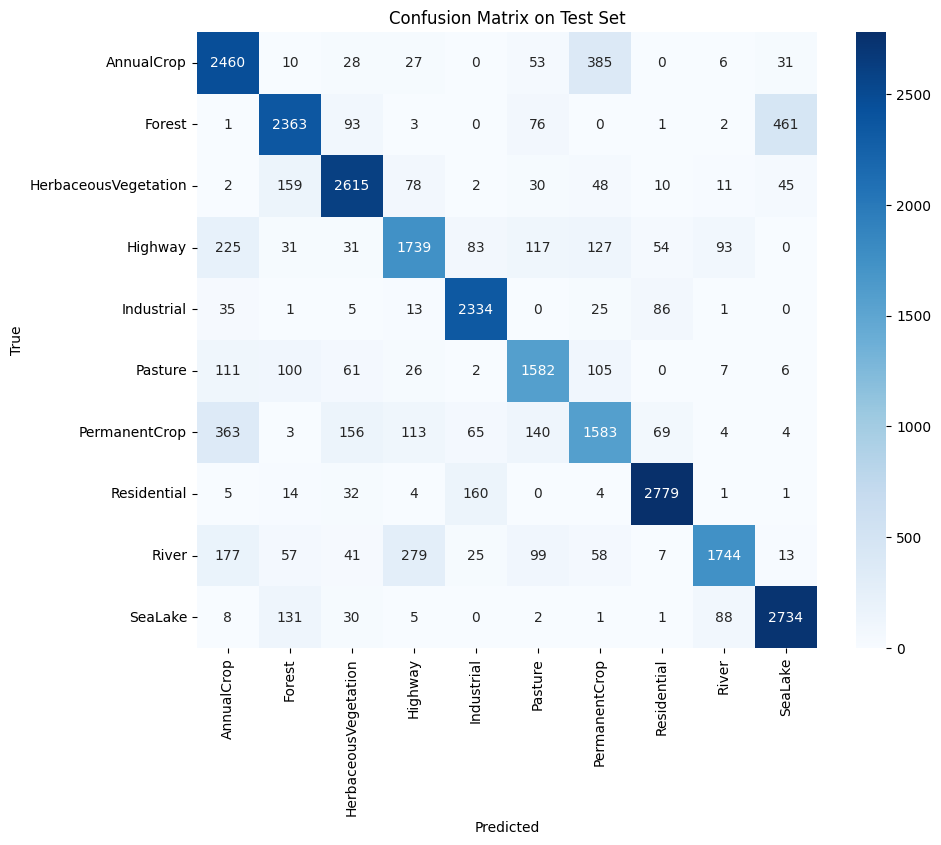

In [20]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=eu_sat_classes, yticklabels=eu_sat_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()